# Vera C. Rubin Observatory Cadence study: kilonovae
Author: Igor Andreoni <andreoni@caltech.edu> <br>
Note: a good amount of material used in this notwbook was taken from: <br>
https://github.com/LSST-nonproject/sims_maf_contrib



In [1]:
%matplotlib inline

import glob
import os
import random
import json

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from astropy.table import Table
import rubin_sim.maf.db as db #import lsst.sims.maf.db as db
from rubin_sim.maf.utils import m52snr #from lsst.sims.maf.utils import m52snr
import rubin_sim.maf.metrics as metrics #import lsst.sims.maf.metrics as metrics
import rubin_sim.maf.plots as plots #import lsst.sims.maf.plots as plots

import rubin_sim.maf.slicers as slicers #import lsst.sims.maf.slicers as slicers
import rubin_sim.maf.metricBundles as metricBundles #import lsst.sims.maf.metricBundles as metricBundles
from rubin_sim.utils import equatorialFromGalactic, hpid2RaDec, _healbin, healbin #from lsst.sims.utils import equatorialFromGalactic, hpid2RaDec, _healbin, healbin
from rubin_sim.utils import getPackageDir #from lsst.utils import getPackageDir
from kneMetrics import KN_lc, KNePopMetric, generateKNPopSlicer, get_filename
import healpy as hp

# Single opsim

Inject synthetic kilonova light curves in a single simulated cadence. This can take a few minutes, depending on how many sources you are injecting.

Found match for {'mej_dyn': 0.005, 'mej_wind': 0.05, 'phi': 30, 'theta': 0.0}
Found match for {'mej_dyn': 0.005, 'mej_wind': 0.05, 'phi': 30, 'theta': 25.8}
Found matches for 2/2           sets of parameters
Querying database SummaryAllProps with no constraint for columns ['rotSkyPos', 'fiveSigmaDepth', 'filter', 'fieldDec', 'fieldRA', 'night', 'observationStartMJD'].
Found 2208619 visits
Running:  ['baseline_nexp1_v1_7_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/plots/plotHandler.py:518: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


Plotting complete.


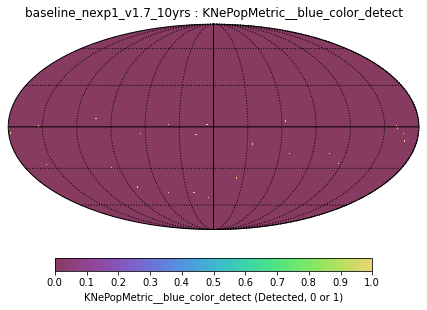

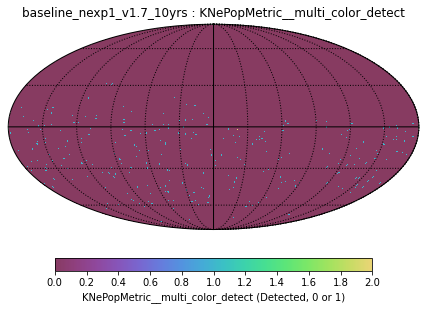

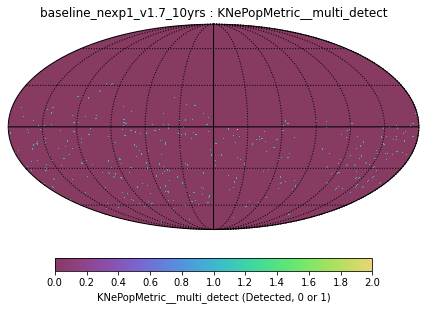

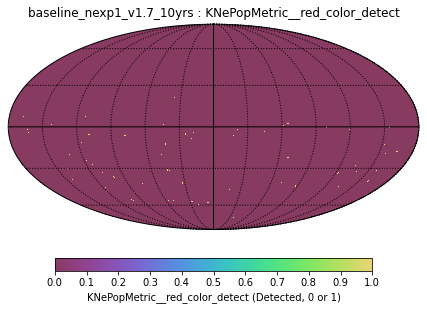

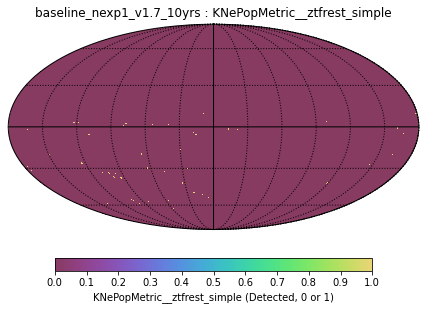

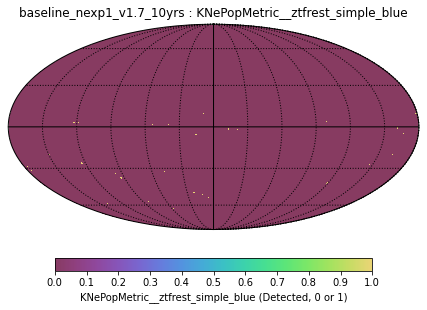

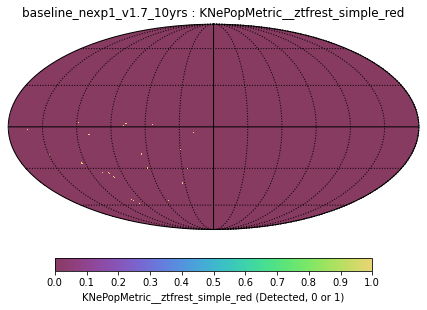

In [2]:
# Minimum and maximum distances for kilonova injection (in Mpc)
dmin = 10
dmax = 600

# Number of light curves
n_events = 5000

cadence_nickname = 'baseline' # only for output filenames

# Output file that collects the efficiency values (transients found/total)
outfile = f"efficiency_{cadence_nickname}_cadence.csv"

# Kilonova parameters
inj_params_list = [{'mej_dyn': 0.005,
              'mej_wind': 0.050,
              'phi': 30,
              'theta': 25.8},
              {'mej_dyn': 0.005,
              'mej_wind': 0.050,
              'phi': 30,
              'theta': 0.0}
             ]
filename = get_filename(inj_params_list)

# Start an output file
with open(outfile, "w") as out:
    out.write("dist_min_Mpc, dist_max_Mpc, metric, found, total, efficiency\n")


# Generate the slicer which puts 10,000 events at random spots on the sphere
slicer = generateKNPopSlicer(seed=42, n_events=n_events, n_files=len(filename), d_min=dmin, d_max=dmax)

#runName = 'six_stripe_scale0.90_nslice6_fpw0.9_nrw0.0v1.7_10yrs'
runName = 'baseline_nexp1_v1.7_10yrs'
#opsdb = db.OpsimDatabase(f'/sims_maf/fbs_1.7.1/new_rolling/{runName}.db')
opsdb = db.OpsimDatabase(f'/sims_maf/fbs_1.7/baseline/{runName}.db')

outDir = 'temp'
resultsDb = db.ResultsDb(outDir=outDir)

# Set outputLc=True if you want light curves
metric = KNePopMetric(outputLc=True, file_list=filename)

# Any special request? For example, only one filer?
sql = ''
# Don't want to try and plot N individual points, 
plotDict = {'reduceFunc': np.sum, 'nside': 64, 'colorMin': 0}
plotFuncs = [plots.HealpixSkyMap()]
summaryMetrics=[metrics.MeanMetric(maskVal=0)]
bundle = metricBundles.MetricBundle(metric, slicer, sql, runName=runName,
                                    plotDict=plotDict, plotFuncs=plotFuncs,
                                    summaryMetrics=summaryMetrics)
bd = metricBundles.makeBundlesDictFromList([bundle])
bgroup = metricBundles.MetricBundleGroup(bd, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
# Plot
bgroup.plotAll(closefigs=False)

# Collect the results in the output file
with open(outfile, "a") as out:
    for key in bd:
        if "USER" in key:
            continue
        found = np.size(np.where(bd[key].metricValues == 1)[0])
        out.write(f"{dmin}, {dmax}, {key}, {found}, {n_events}, {found/n_events}\n")

In [3]:
# Let's see how we do, printing out the metric results.
for key in bd:
    print(key, np.size(np.where(bd[key].metricValues == 1)[0])/5e5)
    print(key, bd[key].summaryValues)

baseline_nexp1_v1_7_10yrs_KNePopMetric_USER 0.0
baseline_nexp1_v1_7_10yrs_KNePopMetric_USER {}
KNePopMetric__blue_color_detect 5.2e-05
KNePopMetric__blue_color_detect {'Mean': 0.0052}
KNePopMetric__multi_color_detect 0.000558
KNePopMetric__multi_color_detect {'Mean': 0.0558}
KNePopMetric__multi_detect 0.00067
KNePopMetric__multi_detect {'Mean': 0.067}
KNePopMetric__red_color_detect 0.00012
KNePopMetric__red_color_detect {'Mean': 0.012}
KNePopMetric__ztfrest_simple 9.4e-05
KNePopMetric__ztfrest_simple {'Mean': 0.0094}
KNePopMetric__ztfrest_simple_blue 5.8e-05
KNePopMetric__ztfrest_simple_blue {'Mean': 0.0058}
KNePopMetric__ztfrest_simple_red 4.6e-05
KNePopMetric__ztfrest_simple_red {'Mean': 0.0046}


Select good data points and record, for each kilonova, the distance at which it was found

In [4]:
#Select good points
#cadence =  'six_stripe_scale0_90_nslice6_fpw0_9_nrw0_0v1_7_10yrs_KNePopMetric_USER'
cadence = 'baseline_nexp1_v1_7_10yrs_KNePopMetric_USER'
index_good = [i for i in np.arange(len(bd[cadence].metricValues.data)) if bd[cadence].metricValues.data[i] is not None]
data_good = bd[cadence].metricValues.data[index_good]
peak_times_good = slicer.slicePoints['peak_time'][index_good]
dist_good = slicer.slicePoints['distance'][index_good]
file_indx_good = slicer.slicePoints['file_indx'][index_good]

# For each metric find the usable distances
for met in ["multi_detect", "blue_color_detect", "red_color_detect", "ztfrest_simple", "ztfrest_simple_red", "ztfrest_simple_blue"]:
    det = [d[met] for d in data_good]
    x = dist_good[np.where(np.array(det)==1)[0]]
    # Create a table
    t = Table([], names=([]))
    t[met] = x
    t.write(f"table_dist_{cadence_nickname}_{met}_{dmin}_{dmax}Mpc.csv", format='csv')
    t

Some extra checks.. where were the light curves injected?

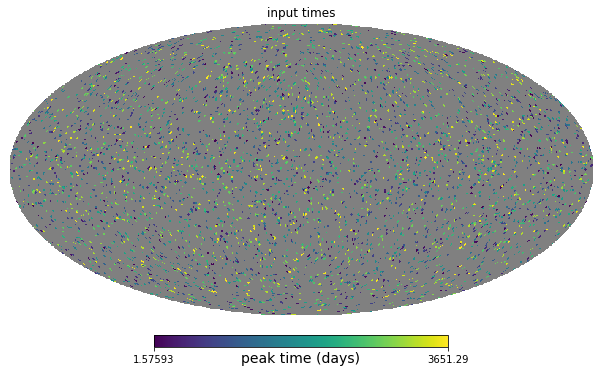

In [5]:
# Check that the positions and times look random
hp.mollview(_healbin(slicer.slicePoints['ra'], slicer.slicePoints['dec'], 
           slicer.slicePoints['peak_time'], 64, reduceFunc=np.mean), unit='peak time (days)',
           title='input times')

### what do the light curves look like?

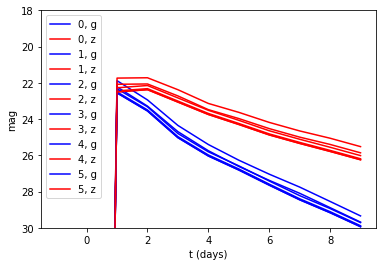

In [6]:
# let's plot up a few of the lightcurves
ivals=[0,1,2,3,4,5]

for i in ivals:
    # Time interval
    t = np.arange(-1, 10)
    # Distance modulus
    distmod = 5*np.log10(slicer.slicePoints['distance'][i]*1e6) - 5.0
    lc = metric.lightcurves.interp(t, 'g', lc_indx=slicer.slicePoints['file_indx'][i])
    plt.plot(t, lc+distmod, color='blue', label='%i, g' % i)
    lc = metric.lightcurves.interp(t, 'z', lc_indx=slicer.slicePoints['file_indx'][i])
    plt.plot(t, lc+distmod, color='red', label='%i, z' % i)
# Axis limits, axis labels
plt.ylim([30,18])
plt.xlabel('t (days)')
plt.ylabel('mag')

# Plot the legend without repeating labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Save
#plt.savefig(f"lc_example_{cadence_nickname}.pdf")

In [7]:
# For when you use multiple models: 
# let's see if there's a preference for which light curve was detected
indxes = np.unique(slicer.slicePoints['file_indx'])
for indx in indxes:
    in_indx = np.where(slicer.slicePoints['file_indx'] == indx)[0]
    n_total = in_indx.size
    print()
    # This simply requires two detections, regardless of band
    detected = bd['KNePopMetric__multi_detect'].metricValues[in_indx].sum()
    print('file indx %i and %f fraction recovered' % (indx, detected/n_total))


file indx 0 and 0.072990 fraction recovered

file indx 1 and 0.061359 fraction recovered


### histogram of the distances
...for some metrics. Add the histogram for more metrics if you wish!

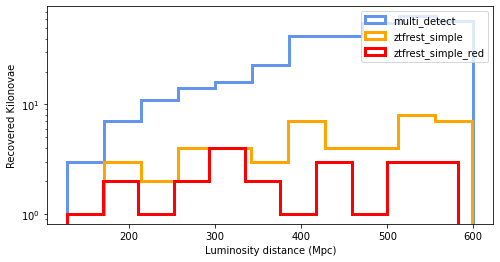

In [8]:
# Create a histogram of distances
n_bins = 11
fig, ax = plt.subplots(figsize=(8, 4))
dict_colors = {"multi_detect": "cornflowerblue", "ztfrest_simple": "orange", "ztfrest_simple_red": "red"}

# For each metric...
for met in ["multi_detect", "ztfrest_simple", "ztfrest_simple_red"]:
    # Only good data
    det = [d[met] for d in data_good]
    # Distances
    x = dist_good[np.where(np.array(det)==1)[0]]
    # plot the histogram (try also cumulative=True)
    n, bins, patches = ax.hist(x, n_bins, density=False, histtype='step',
                               cumulative=False, label=met, linewidth=3, color=dict_colors[met])
ax.set_xlabel("Luminosity distance (Mpc)")
ax.set_ylabel("Recovered Kilonovae")
ax.set_yscale("log")

ax.legend(loc=1)
# Save
#plt.savefig(f"plots/distrib_distance_{cadence_nickname}_notnorm_500k_sources.pdf")
plt.show()

### Light curves!
Note: this will work if, in the first cells, you set the metric with:<br>
        `metric = KNePopMetric(outputLc=True)`

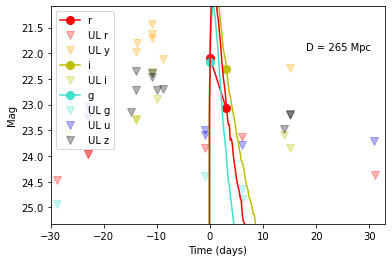

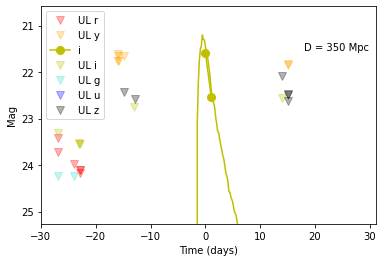

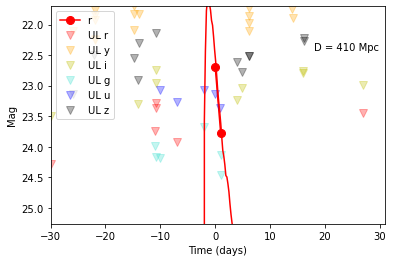

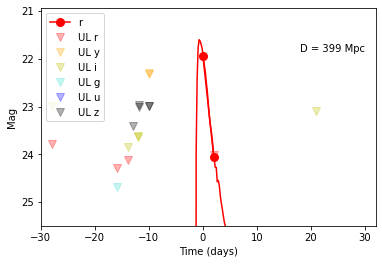

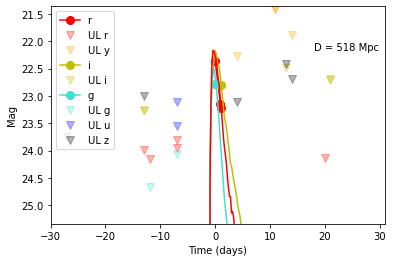

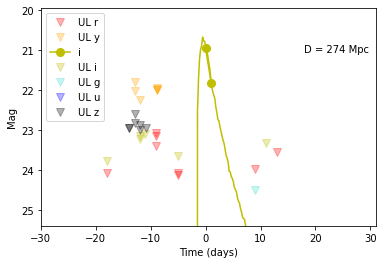

Good: 6
Bad: 265
None: 0


In [9]:
if not os.path.exists('lightcurves'): 
    os.makedirs('lightcurves') 
    
# Initialize variables for counting how many light curves pass certain criteria
good = 0
none = 0
bad = 0

# Define colors
colors = {'u': 'blue', 'g': 'turquoise', 'r': 'red', 'i': 'y', 'z':'k', 'y':'orange'}

# Limits
off_x_right = 2.5 # days
off_x_left = 2.5 # days

# initial MJD of the survey (no need to change it)
mjd0 = 59853.5

indexes = np.arange(len(data_good))
# Shuffle the indexes to avoid biases
random.shuffle(indexes)
for i in indexes:
    # Limit of 5 light curves, it can be removed of course
    if good > 5:
        continue
    if data_good[i]['ztfrest_simple'] == 1:
        # If you want, you can impose a condition on the distance
        #if dist_good[i] > 300:
        #    continue
        
        # for each light curve, initialize the figure
        fig, ax = plt.subplots()
        
        # Create an astropy table 
        lc = Table(data_good[i]['lc'], names=data_good[i]['lc_colnames'])
        lc.sort('t')
        
        # Write the light curve to a flat file
        lc.write(f"lightcurves/lc_{cadence_nickname}_{i}.csv", format='csv')

        # Separate detections and upper limits
        lc_det = lc[np.where(lc['mag'] < lc['maglim'])[0]]
        lc_ul = lc[np.where(lc['mag'] >= lc['maglim'])[0]]
        
        # First detection
        t0 = np.min(lc_det['t'])
        
        # Iterate over filters
        for f in set(lc['filter']):
            # Detection times and mags
            time_det = lc_det['t'][lc_det['filter'] == f]
            mag_det = lc_det['mag'][lc_det['filter'] == f]
            # Upper limits
            time_ul = lc_ul['t'][lc_ul['filter'] == f]
            mag_ul = lc_ul['maglim'][lc_ul['filter'] == f]
            if len(mag_det) > 0:
                ax.plot(time_det - t0, mag_det, color=colors[f], marker='o', markersize=8, label=f)
            if len(mag_ul) > 0:
                ax.plot(time_ul - t0, mag_ul, color=colors[f], marker='v', markersize=8, linestyle = 'None', alpha=0.3, label=f"UL {f}")

        # Times and distance moduls for overplotting the injected light curve
        t = np.linspace(-1, 10, 60)
        distmod = 5*np.log10(dist_good[i]*1e6) - 5.0
        
        # Plot injected light curve
        for f in set(lc_det['filter']):
            lc_inj = metric.lightcurves.interp(t, f, lc_indx=file_indx_good[i])
            ax.plot(t + peak_times_good[i] + mjd0 - t0, lc_inj+distmod, color=colors[f])

        good += 1
        
        # Cosmesis
        ax.legend(loc=2)
        ax.set_xlabel("Time (days)")
        ax.set_ylabel("Mag")
        #ax.set_xlim([np.min(lc_det['t'])-t0-2.5, np.max(lc_det['t'])-t0+2.5])
        #ax.set_ylim([np.max(lc_ul['maglim'])+0.2, np.min(lc_det['mag'])-0.5])
        ymax = np.min(lc_det['mag'])-1
        ymin = np.max(lc_ul['maglim'])+0.2
        ax.set_xlim([np.min(lc_det['t'])-t0-30, np.max(lc_det['t'])-t0+30])
        ax.set_ylim([ymin, ymax])
        
        # Plot the distance
        ax.text(18, ymax - (ymax - ymin)/5, f"D = {int(dist_good[i])} Mpc")
        
        # Save
        #plt.savefig(f"plots/plot_wide_lc_{cadence_nickname}_{i}_{int(dist_good[i])}Mpc.pdf")
        plt.show()
        plt.close()
            
    else:
        bad += 1

print(f"Good: {good}")
print(f"Bad: {bad}")
print(f"None: {none}")

# Multiple OpSims
See also this tutorial: https://github.com/LSST-nonproject/sims_maf_contrib/blob/master/tutorials/Lots_of_runs.ipynb

In [ ]:
# define a dict to collect results from different FAMILIES of opsim
summary_fam = {}

In [ ]:
# Which family of simulations are we interested in?
# * (all)
# List of v1.7 families:
#baseline
#ddf_dither
#euclid_dither
#footprint_tune
#pair_times
#rolling
#rolling_nm
#twi_neo
#twi_pairs
#u_long
#wfd_cadence_drive

# List of v1.5 families
#alt_roll_dust
#baseline
#beta_radar
#bulge
#daily_ddf
#dcr
#DDFs
#filelist
#filter_dist
#footprints
#goodseeing
#greedy_footprint
#rolling
#same_filt
#short_exp
#slurm
#spiders
#sync_10yr_ncsa
#third_obs
#twilight_neo
#u60
#var_expt
#wfd_depth


# List of names of the families to simulate
#families = ["baseline", "ddf_dither", "euclid_dither",
#           "footprint_tune", "pair_times", "rolling",
#            "rolling_nm", "twi_neo", "twi_pairs",
#           "u_long", "wfd_cadence_drive"]

families = ["baseline", "new_rolling"]

# List of FBS directories for each family
fbss = ["fbs_1.7", "fbs_1.7.1"]
#fbss = ["fbs_1.7"] * len(families)


# Name of the output JSON file
#json_name = "families_fbs17_10_800_uniform.json"
json_name = "families_baseVroll_10_300_uniform_GW170817.json"

# How many transients do you want to inject per each simulation?
n_events = 5000

# Max and min distances (Mpc)
dmin = 10
dmax = 300

# Check how many files were found per family
for family, fbs in zip(families, fbss):
    files = glob.glob(f'/sims_maf/{fbs}/{family}/*10yrs.db')
    print(f"Family {family}: {len(files)} files found")


In [ ]:
for family, fbs in zip(families, fbss):
    # Let's use glob to make a list of database files. Replace the path with wherever you have your dbs stored
    files = glob.glob(f'/sims_maf/{fbs}/{family}/*10yrs.db')
    files.sort()
    # Name of the runs
    run_names = [filename.split('/')[-1].replace('_v1.710yrs.db', '').replace('_v1.7_10yrs.db', '') for filename in files]
    
    # Initialize the list of results
    results = []

    # Loop over each file, save the results in a list
    for filename, run_name in zip(files, run_names):
        # REMOVE!!!!
        if 'rolling' in family and not "six_stripe" in filename:
            continue
        opsdb = db.OpsimDatabase(filename)
        # Set each run to save results in a new directory
        outDir = run_name
        resultsDb = db.ResultsDb(outDir=outDir)

        bundleList = []
        sql = ''
        metric = KNePopMetric(outputLc=False)
        slicer = generateKNPopSlicer(seed=42, n_events=n_events, n_files=1, d_min=dmin, d_max=dmax)
        summaryStats = [metrics.MeanMetric(maskVal=0)]
        plotDict = {'reduceFunc': np.sum, 'nside': 64, 'colorMin': 0}
        plotFuncs = [plots.HealpixSkyMap()]
        bundleList.append(metricBundles.MetricBundle(metric, slicer, sql, plotDict=plotDict,
                                                     summaryMetrics=summaryStats,
                                                     plotFuncs=plotFuncs, runName=run_name))

        bd = metricBundles.makeBundlesDictFromList(bundleList)
        bg = metricBundles.MetricBundleGroup(bd, opsdb, outDir=outDir, resultsDb=resultsDb)
        bg.runAll()
        # Plotting
        #bg.plotAll(closefigs=False)

        # NOTE: this was changed from Peter's tutorial, because results.append(bundleList) returned empty summaries
        #results.append(bundleList)
        results.append(bd)
        
    # Dictionary of metric results
    metric_names = bd.keys()
    summary_fam[family] = {}
    summary_fam[family]["run_names"] = run_names
        
    for metric_name in metric_names:
        try:
            summary_means = [result[metric_name].summaryValues['Mean'] for result in results]
        except KeyError:
            continue
        # Update the summary_fam dictionary
        summary_fam[family][metric_name] = {}
        summary_fam[family][metric_name]["summary_means"] = summary_means
        
# Save the results in a JSON file
with open(json_name, "w") as out:
    json.dump(summary_fam, out)